<a href="https://colab.research.google.com/github/nils25696/Nova-Projects/blob/main/Group_project_2223.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced data analysis: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: NILS VAN DER KEMP, 55612
## Student 2: ALEXANDER REBL, 54157


In the solutions for exercises 1 to 5 you should include necessarily one solution using Pandas/scikit learn and one using Spark.

Some useful links:
* [ACM DEBS 2015 Grand Challenge](http://www.debs2015.org/call-grand-challenge.html)

* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [ ]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

## Install software

The following cell will install Spark, if the notebook is running on COLAB.

Before running this cell, you should access the following link [https://drive.google.com/drive/folders/1rPCvd5F-uAoWtMYxvMvRyvL-F_1ihmQ-?usp=sharing](https://drive.google.com/drive/folders/1rPCvd5F-uAoWtMYxvMvRyvL-F_1ihmQ-?usp=sharing) and "Add Shortcut to Drive".


In [ ]:
# Install needed software
# Run this cell once before running the other cells in the notebook
if IN_COLAB:
    !apt-get install openjdk-11-jdk-headless
    !pip install pyspark

!pip install gdown
!mkdir checkpoint

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openjdk-11-jdk-headless is already the newest version (11.0.17+8-1ubuntu2~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘checkpoint’: File exists


In [ ]:
import os
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.2-spark3.2-s_2.12.jar pyspark-shell'

--2022-12-05 15:53:27--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 18.154.132.113, 18.154.132.96, 18.154.132.50, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|18.154.132.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar.1’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.02s   

2022-12-05 15:53:27 (9.60 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar.1’ saved [247880/247880]



## Setup Data

The first time you run the notebook, before running this cell, you should access the following link https://drive.google.com/drive/folders/1rPCvd5F-uAoWtMYxvMvRyvL-F_1ihmQ-?usp=sharing and select the "Add Shortcut to Drive". This will add a shortcut to the datasets to your Google Drive.

The following cell will mount the directory into Colab environment, so that it can be accessed as a local file.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Select the dataset you want to use by uncommnting the appropriate line and running this cell

#Small dataset 100K lines
tiny_df = "/content/drive/MyDrive/group2223/tiny.csv"

#Default dataset 2M lines
default_df = "/content/drive/MyDrive/group2223/sample.csv"

#Huge dataset 173M lines - use only in exercise 0
large_df = "/content/drive/MyDrive/group2223/sorted_data.csv"

## Initialization

import libraries.

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import warnings
warnings.filterwarnings("ignore")

plt.style.use('seaborn')

Let's start spark session and set *log* level to ERROR.

In [ ]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Group project") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

if IN_COLAB :
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.2-s_2.12.jar')
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')

spark.sparkContext.setCheckpointDir("checkpoint")

## Simple statistics

First program prints simple statistics.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(default_df, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

statistics = spark.sql( """SELECT COUNT( DISTINCT medallion) AS num_medallion,
                                  COUNT( DISTINCT hack_license) AS num_license,
                                  MIN( pickup_datetime) AS min_pickup,
                                  MAX( dropoff_datetime) AS max_dropoff,
                                  MAX( trip_time_in_secs) AS max_trip_time,
                                  MAX( trip_distance) AS max_trip_distance,
                                  MAX( total_amount) AS max_total_amount
                                  FROM data""")
statistics.show()

+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|num_medallion|num_license|         min_pickup|        max_dropoff|max_trip_time|max_trip_distance|max_total_amount|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+
|        10867|      20354|2013-01-01 00:00:00|2013-01-21 00:11:45|        10800|            95.85|           465.0|
+-------------+-----------+-------------------+-------------------+-------------+-----------------+----------------+



## Ploting information

Example on how to plot information using matplotlib.

### First plot

This first plot helps showing that data has several invalid values.

Let's plot the pickups - you can see that there are points quite far from the expected locations.

Plotting pickups


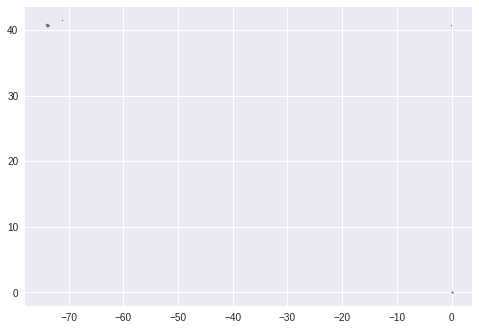

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(default_df, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")

# Plotting all points is probably too much in many computers, so lets plot only a few 1000's
data = spark.sql( "SELECT * FROM data LIMIT 1000")
pickups = data.collect()

print('Plotting pickups')
plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            s=1)
plt.show()


### Plotting heatamps

This example shows how to **plot heatmaps** and how to **create a grid** with coordinates -- note that we need to group nearby coordinates together or (almost) every coordinate will be unique.

The example creates a grid, with cell of 150m of side (commented out the code for cells of 500m of side). It also filters out data that is outside of the area of interest - defined by northLatitude, southLatitude, westLatitude, eastLatitude coordinates.

\[From ACM DEBS 2015 Grand Challenge page\]

**Question 1**: Is the earth flat or how to map coordinates to cells?

**Answer**: For the challenge we allow a simplified flat earth assumption for mapping coordinates to cells in the queries. You can assume that a distance of 500 meter south corresponds to a change of 0.004491556 degrees in the coordinate system. For moving 500 meter east you can assume a change of 0.005986 degrees in the coordinate system.

Plotting pickups


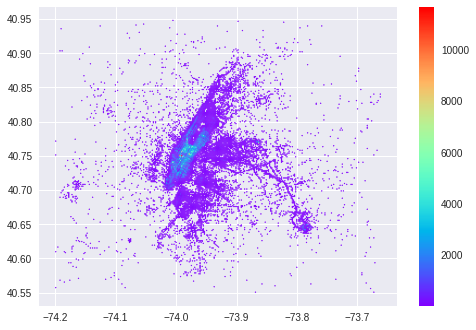

Plotting dropoffs


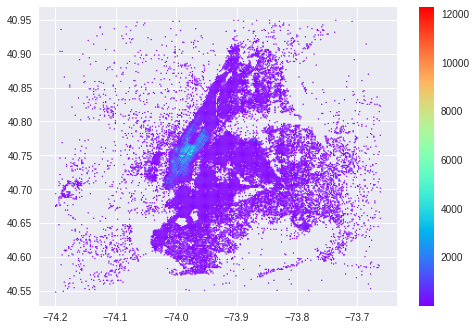

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Squares of 500 meters
# latitudeStep = 0.004491556
# longitudeStep = 0.005986
# northLatitude = 41.474937 - 0.5 * latitudeStep
# southLatitude = northLatitude - 300 * latitudeStep
# eastLongitude = -74.913585 - 0.5 * longitudeStep
# westLongitude = eastLongitude + 300 * longitudeStep

# Squares of 150 meters
latitudeStep = 0.0013474668
longitudeStep = 0.0017958
northLatitude = 40.95
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.2
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(default_df, format="csv",
                         sep=",", schema=mySchema, header="false")

# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude,
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude,
                                    latround(dropoff_latitude) AS dropoff_latitude,
                                    payment_type, fare_amount, mta_tax,
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequency for pickups
pickupsDF = spark.sql( """SELECT pickup_longitude, pickup_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY pickup_longitude, pickup_latitude""")
pickups = pickupsDF.collect()

print('Plotting pickups')
p = plt.scatter([row.pickup_longitude for row in pickups],
            [row.pickup_latitude for row in pickups],
            c=[row.cnt for row in pickups],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

# Statistics for dropoffs
dropoffsDF = spark.sql( """SELECT dropoff_longitude, dropoff_latitude, count(*) AS cnt
                                  FROM data
                                  GROUP BY dropoff_longitude, dropoff_latitude""")
dropoffs = dropoffsDF.collect()

print('Plotting dropoffs')
p = plt.scatter([row.dropoff_longitude for row in dropoffs],
            [row.dropoff_latitude for row in dropoffs],
            c=[row.cnt for row in dropoffs],s=1,cmap="rainbow")
plt.colorbar(p)
plt.show()

## Exercise 0: another simple statistics

This example computes, for each license, the number of trips performed.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

### Code: Spark

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(tiny_df, format="csv",
                         sep=",", schema=mySchema, header="false")
dataset.createOrReplaceTempView("data")
statistics = spark.sql( """SELECT hack_license, COUNT(*) AS cnt FROM data GROUP BY hack_license""")
statistics.show()

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

+--------------------+---+
|        hack_license|cnt|
+--------------------+---+
|130328475AD7427AF...| 10|
|D4F2AE0988ECB2E42...|  9|
|DD97899ACAC51EF31...|  7|
|A7C47E60941315A0E...| 17|
|9911D66A4A796752D...|  8|
|88CB7A1006DB18438...| 24|
|069B5562096AF7684...|  7|
|28A7C858D9231A3EC...| 20|
|A7EE9AEDB7325F55F...| 18|
|4B6EFCBC110DB539E...| 17|
|AA33AA1CACC8C26E7...| 10|
|921E1C7C91CDCF1C6...| 19|
|616E057B1ACDB7B28...| 15|
|EFA12B2F45FC838E1...| 14|
|D0D1271283601BF84...| 27|
|138B0A7B7D3B898E4...| 12|
|0FBF11956EE14B253...| 11|
|8821CA9250E34A869...| 28|
|BE047851D97506885...|  7|
|02856AFC22881ABCA...| 16|
+--------------------+---+
only showing top 20 rows

Runtime = 3.2970333099365234


### Results (Spark)

**Tiny dataset**

The time to process the tiny dataset was : **3.2970333099365234** seconds.

**Default dataset**

The time to process the small dataset was : **17.3543484210968** seconds.

**Large dataset**

The time to process the large dataset was : **617.2419986724854** seconds.


### Code: Pandas library

In [ ]:
start_time = time.time()
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = pd.read_csv(tiny_df,names=mySchema)
result = dataset.groupby("hack_license").count()
display(result)

end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


,medallion,pickup_datetime,dropoff_datetime,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
hack_license,,,,,,,,,,,,,,,,
000CCA239BFDC0ABE2895AC9086C4290,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
001C8AAB90AEE49F36FCAA7B4136C81A,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
0025133AD810DBE80D35FCA8BF0BCA1F,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11,11
002FE84F0EA642650A650C2BE875DDD3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0031E634F79DA0E6B01239A8017F5928,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FFEE627F76A3A498DA53E200821FDEE9,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
FFF20BA1518E14B3B23F79DDDE1CA7E6,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8
FFF5AD65C673251C1F275CF5B43EC414,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Runtime = 0.7798910140991211


### Results (Pandas)

**Tiny dataset**

The time to process the tiny dataset was : **0.7798910140991211** seconds.

**Default dataset**

The time to process the default dataset was : **11.762796640396118** seconds.

**Large dataset**

**Error message:** "Your session crashed after using all available RAM. If you are interested in access to high-RAM runtimes, you may want to check out Colab Pro."

#### Results discussion

As you can see, for the tiny and the default dataset the time differences are very small. However, when it comes to the large dataset you can observe, that pandas fails to execute the code while spark manages to do so. The error message occurring at pandas tells us that it failed because it used all available RAM. This is because pandas runs this operation only on one single machine, and thus consumed all the memory. Spark, whereas, is able to distribute the dataframe to multiple machines and can therefore do map reduce tasks like grouping and aggregating data in parallel.

## Exercise 1

Let's start by trying to help the city to identify which new bus routes should be introduced. To this end, you should find the most frequent routes whose distance is above a given treshold (defined by you).

For establishing these routes, we suggest that you use a grid of 500m of side.

In [ ]:
# determine the columns data types
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

# read the csv-file as spark dataframe
dataset = spark.read.load(default_df, format="csv",
                         sep=",", schema=mySchema, header="false")

# register the coordinate rounding functions to spark again
spark.udf.register("longiRound", longiRound)
spark.udf.register("latRound", latRound)

# create the spark dataframe showing the most frequent routes (above a treshold of 1 mile)
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql("""SELECT pickup_lon_adj, dropoff_lon_adj, pickup_lat_adj, dropoff_lat_adj
                              ,COUNT(medallion) AS route_frequency
                              FROM(
                                  SELECT *
                                  ,longiRound(pickup_longitude) AS pickup_lon_adj
                                  ,longiRound(dropoff_longitude) AS dropoff_lon_adj
                                  ,latRound(pickup_latitude) AS pickup_lat_adj
                                  ,latRound(dropoff_latitude) AS dropoff_lat_adj
                                  FROM(
                                      SELECT *
                                      FROM data
                                      WHERE trip_distance > 1 AND
                                      pickup_longitude >= """ + str(eastLongitude) + """ AND
                                      pickup_longitude <=  """ + str(westLongitude) + """ AND
                                      dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                      dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                      pickup_latitude <= """ + str(northLatitude) + """ AND
                                      pickup_latitude >= """ + str(southLatitude) + """ AND
                                      dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                      dropoff_latitude >=  """ + str(southLatitude) + """
                                      )
                                  )
                              GROUP BY pickup_lon_adj, dropoff_lon_adj, pickup_lat_adj, dropoff_lat_adj
                              ORDER BY COUNT(medallion) DESC
                              """)
filteredDataDF.createOrReplaceTempView("data")
filteredDataDF.show()

+------------------+------------------+------------------+------------------+---------------+
|    pickup_lon_adj|   dropoff_lon_adj|    pickup_lat_adj|   dropoff_lat_adj|route_frequency|
+------------------+------------------+------------------+------------------+---------------+
|-73.93691530000001|-73.93691530000001|40.757985981000004|40.757985981000004|            572|
|-73.96564810000001|-73.96564810000001|     40.7593334478|     40.7593334478|            260|
|-73.85071690000001|-73.85071690000001|     40.8374865222|     40.8374865222|            237|
|       -73.9782187|       -73.9782187|40.631324101800004|40.631324101800004|            166|
|-74.00874730000001|-74.00874730000001|     40.7121721098|     40.7121721098|            163|
|       -73.9854019|       -73.9997683|     40.7593334478|     40.7593334478|            160|
|       -73.9458943|       -73.9458943|     40.7835878502|     40.7835878502|            155|
|-73.92973210000001|-73.92973210000001|     40.7472062466|  

#### Discussion

First, we filtered out every trip with a distance below 1 mile, as we consider such routes to be too short and thus not worth it to introduce a new bus line. In the next step, we used the pre-defined longiRound and latiRound functions to round both the pickup and dropoff coordinates to the center of a grid cell. Finally, we counted the frequency of each route by grouping all rounded coordinates, as we need each combination of pickup and dropoff point, to identify a route. As a result, the code gives us the top 20 most frequent routes.

## Exercise 2

The taxi trips can be classified in two categories, depending on whether the client has given a tip or not (or alternatively in three categories - no tip, low percentage tip, high percentage tip). Propose a method to predict the class of a given trip (for the prediction, you cannot use the value of the tip).


Precision: 0.9273500049421766
Recall: 0.9996803409696324
Accuracy: 0.97048


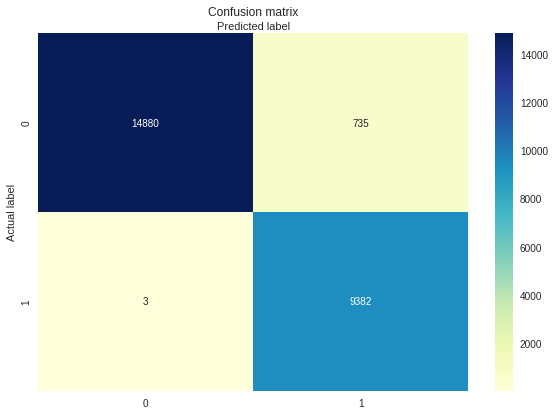

In [ ]:
# read default dataset in pandas
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = pd.read_csv(tiny_df,names=mySchema)

# new dataframe with the attributes payment_type and tip_amount
dataset_classification = dataset[["payment_type","tip_amount"]]

# convert the value of the trip amount
dataset_classification.loc[dataset_classification['tip_amount'] > 0, 'tip_amount'] = 1

# convert the value of the payment type
# cash
dataset_classification.loc[dataset_classification['payment_type'] == "CSH", 'payment_type'] = 1
# card
dataset_classification.loc[dataset_classification['payment_type'] == "CRD", 'payment_type'] = 0

# unkown payment type
dataset_classification.loc[dataset_classification['payment_type'] == "UNK", 'payment_type'] = 2
dataset_classification.loc[dataset_classification['payment_type'] == "DIS", 'payment_type'] = 3
dataset_classification.loc[dataset_classification['payment_type'] == "NOC", 'payment_type'] = 4

# build the model
from sklearn.model_selection import train_test_split
x = dataset_classification.drop(['tip_amount'], axis = 1) # Features
y = dataset_classification['tip_amount'] # Target variable

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=2)

# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

# classification evaluation
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# print the performance values
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#### Discussion

In this code we built a classification model with the payment type (cash or card) to predict the two categories (tip or no tip). At the end we are evaluating it with a Confusion Matrix. This matrix shows that most of the values are predicted right, only (363+9126=9489) 9489 values are predicted wrong. The Precision of the model is 96,40%, which is quite high because it measures how precise/accurate your model is (out of those predicted positive, how many of them are actually positive). The Recall with 99,85% is also high. It shall be the model metric we use to select our best model when there is a high cost associated with False Negative. The Accuracy with 98,10% is high as well. It is a metric describing how the model performs across all classes. So as our code shows it is possible to build a accuracte classification model for the prediction of the two categories (tip or no tip) only using the payment type.

## Exercise 3

The third question intends to help taxi drivers to decide to which area of the city they should go next. To this end, we could have a web site/mobile app where the drivers could check the best area at a given moment. To support such application efficiently, it would be necessary to have a pre-computed index with the value for each area and period of time (e.g. combining the week day and a period of one hour).

You should create the program to create such index. The output tuples should be something like: longitude latitude day_of_week hour value.

Define your own metric for the value of an area. Parameters that may be included in such metric include: the number of pickups in the area, the amount collected in the trip, the average time a taxi is idle in the area, etc.

Besides presenting the code, explain the rationale of your solution.

**Note:** SQL functions date(col), dayofweek(col) and hour(col) return, respectively, the date, day of week and hour of a datatime in column col.

In [ ]:
# determine the columns data types
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

# read the csv-file as spark dataframe
dataset = spark.read.load(default_df, format="csv",
                         sep=",", schema=mySchema, header="false")

# register the coordinate rounding functions to spark again
spark.udf.register("longiRound", longiRound)
spark.udf.register("latRound", latRound)

# create the spark dataframe to show the coordinates with best scores per weekday and hour (approach explained in the discussion below)
# trips with a distance of 0 miles are being ignored here
dataset.createOrReplaceTempView("data")
filteredDataDF = spark.sql("""SELECT DISTINCT pickup_long_adj AS pickup_longitude
                              ,pickup_lat_adj AS pickup_latitude
                              ,weekday
                              ,hour
                              ,CONCAT(CAST(ROUND(score, 2) AS STRING), ' / 100') AS score
                              FROM(
                                  SELECT *
                                  ,MAX(score) OVER(PARTITION BY weekday, hour) AS best_score
                                  FROM(
                                      SELECT *
                                      ,(pickup_rank / MAX(pickup_rank) OVER(PARTITION BY agg_help)) * 100 AS relative_pickup_rank
                                      ,(price_rank / MAX(price_rank) OVER(PARTITION BY agg_help)) * 100 AS relative_price_rank
                                      ,(tip_rank / MAX(tip_rank) OVER(PARTITION BY agg_help)) * 100 AS relative_tip_rank
                                      ,((pickup_rank / MAX(pickup_rank) OVER(PARTITION BY agg_help)) * 0.4
                                         +(price_rank / MAX(price_rank) OVER(PARTITION BY agg_help)) * 0.3
                                         +(tip_rank / MAX(tip_rank) OVER(PARTITION BY agg_help)) * 0.3) * 100 AS score
                                      FROM(
                                          SELECT *
                                          ,DENSE_RANK() OVER(ORDER BY pickups_per_area, weekday, hour) AS pickup_rank
                                          ,DENSE_RANK() OVER(ORDER BY avg_price_per_area, weekday, hour) AS price_rank
                                          ,DENSE_RANK() OVER(ORDER BY avg_tip_percentage_per_area, area) AS tip_rank
                                          ,1 AS agg_help
                                          FROM(
                                              SELECT longiRound(pickup_longitude) AS pickup_long_adj
                                              ,latRound(pickup_latitude) AS pickup_lat_adj
                                              ,CONCAT_WS('_', CAST(longiRound(pickup_longitude) AS STRING), CAST(latRound(pickup_latitude) AS STRING)) AS area
                                              ,WEEKDAY(pickup_datetime) AS weekday
                                              ,HOUR(pickup_datetime) AS hour
                                              ,COUNT(medallion) OVER(PARTITION BY longiRound(pickup_longitude), latRound(pickup_latitude)) AS pickups_per_area
                                              ,MEAN(total_amount) OVER(PARTITION BY longiRound(pickup_longitude), latRound(pickup_latitude)) AS avg_price_per_area
                                              ,MEAN((tip_amount / total_amount)) OVER(PARTITION BY longiRound(pickup_longitude), latRound(pickup_latitude)) AS avg_tip_percentage_per_area
                                              FROM(
                                                  SELECT *
                                                  FROM data
                                                  WHERE
                                                  trip_distance <> 0 AND
                                                  pickup_longitude >= """ + str(eastLongitude) + """ AND
                                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                                  dropoff_latitude >=  """ + str(southLatitude) + """
                                                  )
                                              )
                                          )
                                      )
                                  ) WHERE score = best_score
                           """)
filteredDataDF.createOrReplaceTempView("data")
print("Coordinates with best scores per weekday and hour:\n")
filteredDataDF.show()

# convert the spark dataframe to a pandas dataframe
DataDF = filteredDataDF.toPandas()

# write a function to demonstrate what the program could look like in an app or on a website
def where_to_go_next(weekday_no, hour_of_day):
  return DataDF[(DataDF["weekday"] == weekday_no) & (DataDF["hour"] == hour_of_day)]

# example what it could look like in an app or on a website.
# the user enters the weekday (here 6, i.e. sunday) and the hour of the day (here 3) and gets the coordinates with the highest score, so they know where to go next.
print("\nExample of output tuple, looking for weekday 6, hour 3:\n")
display(where_to_go_next(6,3))

Coordinates with best scores per weekday and hour:

+------------------+---------------+-------+----+-----------+
|  pickup_longitude|pickup_latitude|weekday|hour|      score|
+------------------+---------------+-------+----+-----------+
|       -73.8632875|  40.7687657154|      0|   0|92.87 / 100|
|       -73.8632875|  40.7687657154|      0|   1|92.87 / 100|
|-73.87226650000001|  40.7741555826|      0|   2|90.95 / 100|
|       -73.8632875|  40.7687657154|      0|   3|92.87 / 100|
|       -73.8740623|  40.7741555826|      0|   4|92.18 / 100|
|       -73.8740623|  40.7741555826|      0|   5|92.18 / 100|
|-73.87226650000001|  40.7741555826|      0|   6|90.95 / 100|
|       -73.8632875|  40.7687657154|      0|   7|92.87 / 100|
|       -73.8632875|  40.7687657154|      0|   8|92.87 / 100|
|       -73.8632875|  40.7687657154|      0|   9|92.87 / 100|
|       -73.8632875|  40.7687657154|      0|  10|92.87 / 100|
|       -73.8632875|  40.7687657154|      0|  11|92.87 / 100|
|       -73.863287

,pickup_longitude,pickup_latitude,weekday,hour,score
147,-74.01593050000001,40.714867043400005,6,3,83.88 / 100


#### Discussion

To find the best area for a taxi driver to go next, we used a metric including the following parameters: the average number of pickups in an area, the average total amount paid in an area and the average percentage of tip from the total amount paid in an area, weighted with the factors 0.4, 0.3 and 0.3 respectively. This is because we think, that the most important factor is how many people are looking for a taxi in a specific area in general, and then how much money both the taxi company and the driver can expect from a client, equally weighted.

To get the best score for an area we first ranked each of the parameters per weekday and hour of the day (the higher the rank, the better), then relativized each rank by dividing it by the respective maximum rank and then applied the weights to each relative rank. In the end, we get a datatable showing only the area with the best score for every combination of weekday and hour of the day. In addition to that, we wrote a function which should simulate how an app or website could make use of this data. By feeding the function with a weekday and a hour input variable, a taxi driver can immediately see the coordinates of the best location to go next, as well as its respective score.

As you can see, there are some areas which seem to be the best to go for a lot of daytimes. This might be for example high-frequency areas, where many people pickup a taxi, like Times Square.

## Exercise 4

The fourth question intends to help define the location of taxi ranks (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to travel to reach the taxi rank.

Consider that you want to establish, at least, 100 taxi ranks but no more than 150 - present the code that defines the number and locations of the ranks.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, you should focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). Use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92
```

**Suggestion:** Plot your results as a heatmap, with the color being a measurement of the value of the taxi rank; use the visual feedback to enhance your solution.

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# define the square to look at
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92

# determine the columns data types
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(tiny_df, format="csv",
                         sep=",", schema=mySchema, header="false")

# create new dataset with coordinates reduced to the defined square
# this time we use the actual coordinates, i.e. not the rounded ones
dataset.createOrReplaceTempView("data")
NY_df = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                             dropoff_datetime, trip_time_in_secs, trip_distance,
                             pickup_longitude, pickup_latitude,
                             payment_type, fare_amount, mta_tax,
                             tip_amount, tolls_amount, total_amount
                      FROM data
                      WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                      pickup_longitude <=  """ + str(westLongitude) + """ AND
                      dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                      dropoff_longitude <=  """ + str(westLongitude) + """ AND
                      pickup_latitude <= """ + str(northLatitude) + """ AND
                      pickup_latitude >= """ + str(southLatitude) + """ AND
                      dropoff_latitude <=  """ + str(northLatitude) + """ AND
                      dropoff_latitude >=  """ + str(southLatitude))
NY_df.createOrReplaceTempView("data")

# function to perform clustering of dataset data with k clusters, returning the silhouette score
def evaluate( dataset, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score

# create the features column
assembler = VectorAssembler(inputCols = ('pickup_longitude','pickup_latitude'), outputCol = "features")
datasetKM = assembler.transform(NY_df)

# for each value from 100 to 150 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(100,151):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(datasetKM,i)}).to_frame().T], ignore_index=True)

# print the "best" number of clusters
k = int(df.nlargest(1,"score")["num"].values[0])
print("The 'best' number of clusters is:", k)

The 'best' number of clusters is: 144


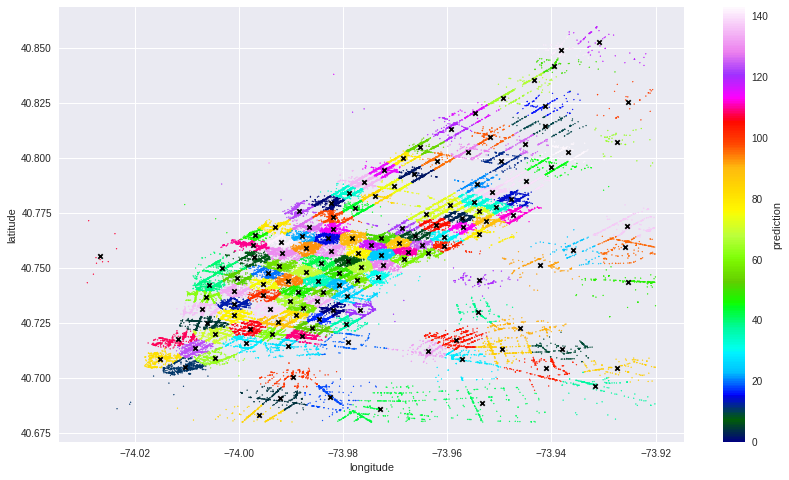

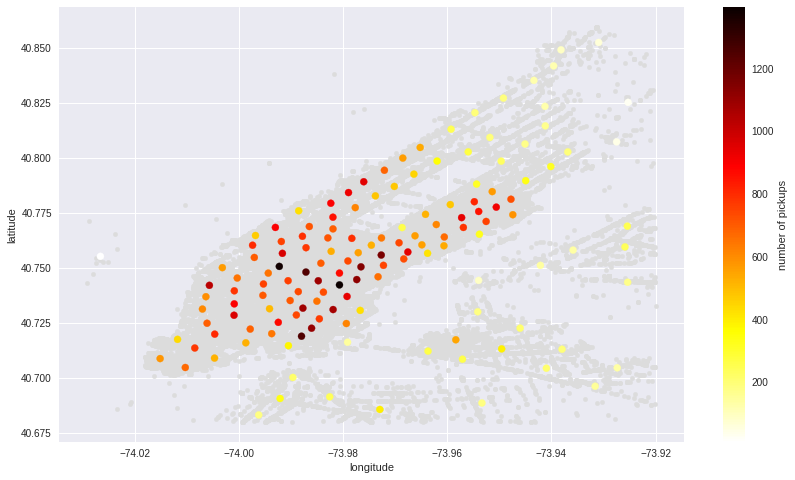

In [ ]:
# do the predictions based on the calculated number of clusters (k)
kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(datasetKM)
predictions = model.transform(datasetKM)
predictionsPD = predictions.toPandas()

# calculate the coordinates of each cluster's center
centers = model.clusterCenters()
df = pd.DataFrame(centers, columns = ["longitude", "latitude"])
df.reset_index(inplace=True)

# join cluster centers to our dataframe and create a new dataframe showing only the cluster number, cluster center coordinates and the number of pickups per cluster
predictionsPD = predictionsPD.merge(df, left_on = "prediction", right_on = "index", how = "left")
counts = pd.DataFrame(predictionsPD.groupby(["prediction", "longitude", "latitude"])["prediction"].count().reset_index(name="number of pickups"))

# plot both the clusters and their centers in the same heatmap
fig1 = plt.figure(figsize = (14,8))
ax0 = fig1.add_subplot()
ax1 = fig1.add_subplot()
predictionsPD.plot.scatter(x = "pickup_longitude", y = "pickup_latitude", c = "prediction", s = 1, cmap = "gist_ncar", ax = ax0)
counts.plot.scatter(x = "longitude", y = "latitude", ax = ax1, c = "black", marker = "x")

# plot the cluster centers, coloured based on the number of pickups per cluster
fig2 = plt.figure(figsize = (14,8))
ax2 = fig2.add_subplot()
ax3 = fig2.add_subplot()
predictionsPD.plot.scatter(x = "pickup_longitude", y = "pickup_latitude", c = "gainsboro", ax = ax2)
counts.plot.scatter(x = "longitude", y = "latitude", ax = ax3, c = "number of pickups", cmap = "hot_r", s = 50)

#### Discussion

To find the best locations for a number of taxi ranks, we need to look at the pickup coordinates of clients and create different clusters from coordinates located closest to each other. For this, we first need to find out the best amount of clusters, which we did using K-means for the value from 100 to 150, since this is the range of taxi ranks required. The number of clusters with the highest silhouette score, i.e. quality is 144, so this is the amount of clusters we used (in order to have a lower run time, we did this calculation with the tiny dataset, even though it is the least representative of our 3 datasets).

With the K-means model, we assigned each location (i.e. combination of longitude and latitude) to a cluster and plotted it. The different colours in the plot represent the different clusters. In addition, we computed the centers for each cluster and plotted them in the same graph, displayed by black crosses. These centers represent the 144 locations where taxi ranks should be built, to minimize the distance a client needs to travel.

In the lower plot we showed the importance of each taxi rank to be introduced, based on the number of pickups in that area. The darker a taxi rank, the more pickups there are in this area, i.e. the higher the need for a taxi rank to be built and vice versa.

## Exercise 5

Propose a problem that you think would be useful to solve with the given dataset.

**Explain the problem you propose to solve**

Text(0, 0.5, 'latitude')

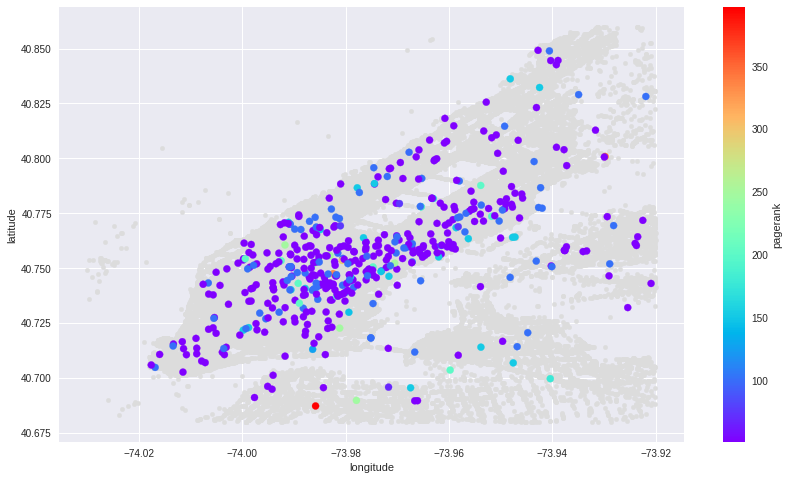

In [ ]:
# determine the columns data types
mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

# read the csv-file as spark dataframe
dataset = spark.read.load(tiny_df, format="csv",
                         sep=",", schema=mySchema, header="false")

# register the coordinate rounding functions to spark again
spark.udf.register("longiRound", longiRound)
spark.udf.register("latRound", latRound)

# create the spark dataframe showing the most frequent routes (above a treshold of 1 mile)
dataset.createOrReplaceTempView("data")
preprocDF = spark.sql("""SELECT CONCAT('(',pickup_longitude,',',pickup_latitude,')') AS src
                         ,CONCAT('(',dropoff_longitude,',',dropoff_latitude,')') AS dst
                         ,longiRound(pickup_longitude) AS pickup_longitude
                         ,longiRound(dropoff_longitude) AS dropoff_longitude
                         ,latRound(pickup_latitude) AS pickup_latitude
                         ,latRound(dropoff_latitude) AS dropoff_latitude
                         FROM(
                             SELECT *
                             FROM data
                             WHERE trip_distance <> 0 AND
                             pickup_longitude >= """ + str(eastLongitude) + """ AND
                             pickup_longitude <=  """ + str(westLongitude) + """ AND
                             dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                             dropoff_longitude <=  """ + str(westLongitude) + """ AND
                             pickup_latitude <= """ + str(northLatitude) + """ AND
                             pickup_latitude >= """ + str(southLatitude) + """ AND
                             dropoff_latitude <=  """ + str(northLatitude) + """ AND
                             dropoff_latitude >=  """ + str(southLatitude) + """
                             )"""
                      )
preprocDF.createOrReplaceTempView("data")

edges = spark.sql( """SELECT src, dst, 'trip' FROM data""")

vertex = spark.sql( """SELECT src as id, pickup_longitude as longitude,
pickup_latitude as latitude FROM data
UNION
SELECT dst as id, dropoff_longitude as longitude,
dropoff_latitude as latitude FROM data""")

# import additional packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col
from graphframes import *

# build graphframe from vertex and edges data and run pagerank algorithm
g = GraphFrame(vertex, edges)
results = g.pageRank(resetProbability=0.01, maxIter=10)
rank = results.vertices.select("id", "pagerank")

# clean data
df1 = rank.withColumn('x', split(rank['id'], ',').getItem(0)) \
       .withColumn('y', split(rank['id'], ',').getItem(1))
df2 =  df1.toPandas()
x = df2['x'].str.strip("(")
y = df2['y'].str.strip(")")
df2['x_adj'] = x
df2['y_adj'] = y
df2['x_adj'] = df2['x_adj'].astype(float)
df2['y_adj'] = df2['y_adj'].astype(float)
df2['pagerank'] = df2['pagerank'].astype(float)
df2['pagerank'] = df2['pagerank'].astype(float)
df3 = df2[df2['pagerank'] > 50]

# plot all pageranks and highlight the ones greater than 50 using the rainbow colouring scheme
fig = plt.figure(figsize = (14,8))
ax0 = fig.add_subplot()
ax1 = fig.add_subplot()
df2.plot.scatter(x = "x_adj", y = "y_adj", c = "gainsboro", ax = ax0)
df3.plot.scatter(x = "x_adj", y ="y_adj", c ="pagerank", s = 50, cmap = "rainbow", ax = ax1)
plt.xlabel("longitude")
plt.ylabel("latitude")

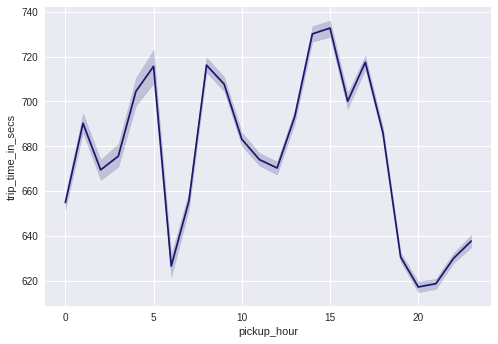

In [ ]:
# read default dataset in pandas
mySchema = ["medallion", "hack_license", "pickup_datetime",
            "dropoff_datetime", "trip_time_in_secs", "trip_distance",
            "pickup_longitude", "pickup_latitude", "dropoff_longitude",
            "dropoff_latitude", "payment_type", "fare_amount",
            "surcharge", "mta_tax", "tip_amount",
            "tolls_amount", "total_amount"]

dataset = pd.read_csv(default_df,names=mySchema)

# create column "pickup_hour" and plot the trip time per pickup hour
dataset["pickup_datetime"] = pd.to_datetime(dataset["pickup_datetime"])
dataset["pickup_hour"] = dataset["pickup_datetime"].dt.hour
sns.lineplot(data = dataset, x= "pickup_hour", y = "trip_time_in_secs", color = "midnightblue")

#### Discussion

Here we tried to find out, what are the vertices of the taxies with the highst pagerank in NYC. So these kind of vertices are the points of the city with the highest taxi traffic. In the plot you can see the points (the light grey points are all the vertices and the ones highlighted in rainbow colours are the vertices with a pagerank higher than 50). Important for us are the vertices with a pagerank higher than 50 because these are the points with a high amount of taxi traffic (could be also 25, 100 etc., important is that you are filtering most of the vertices with a smaller score out). Our suggestion for the taxi drivers is to avoid the points with a high pagerank during the rush hours because of the many traffic jams in NYC. In the second plot you can see the average trip time in seconds depending on the pickup hour. In this plot you can identify the rush hour times (e.g. 5:00, 8:00, 15:00). Our advice would be to avoid the points with the higher pageranks during these times.